# **Urban Sound 8K Preprocessing**

# **Content**
1. [Data Analysis](#1)
    * [Veriable Description](#2)
    * [Audio File Sample](#3)
    * [Load Audio File with Librosa](#4)
1. [Spectrogram Creation](#5)
    * [What is Spectrogram](#6)
    * [Spectrogram Creation Function](#7)
1. [Preprocessing Steps](#8)
    * [Image Resize and grayscale](#9)
    * [Data convert to matrix and save into dataframe](#10) 
    * [Saving data as test and train](#11)

In [1]:
# Used Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from tqdm import tqdm
import csv

import librosa
import librosa.display
import IPython.display as ipd # Used to listen to the audio file
import cv2 as cv

from sklearn.model_selection import train_test_split

<a id=1></a>
# Data Analysis

In [2]:
df = pd.read_csv("UrbanSound8K.csv")
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

<a id=2></a>
## Veriable Description
1. slice_file_name: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, 
    where:
    * [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
    * [classID] = a numeric identifier of the sound class (see description of classID below for further details)
    * [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
    * [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence
1. fsID: The Freesound ID of the recording from which this excerpt (slice) is taken
1. start: The start time of the slice in the original Freesound recording
1. end: The end time of slice in the original Freesound recording
1. salience: A (subjective) salience rating of the sound. 1 = foreground, 2 = background
1. fold: The fold number (1-10) to which this file has been allocated
1. classID:A numeric identifier of the sound class:
    * 0 = air_conditioner
    * 1 = car_horn
    * 2 = children_playing
    * 3 = dog_bark
    * 4 = drilling
    * 5 = engine_idling
    * 6 = gun_shot
    * 7 = jackhammer
    * 8 = siren
    * 9 = street_music
1. class: The class name; air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.


<a id=3></a>
## Audio File Sample 
* Before the load we will check 3 audio file with IPython.

In [3]:
audio_file1 = "audio/14110-4-0-1.wav" # class: drilling
audio_file2 = "audio/7061-6-0-0.wav" # class: gun_shot
audio_file3 = "audio/9031-3-1-0.wav" # class: dog_bark

In [5]:
ipd.Audio(audio_file1)

In [6]:
ipd.Audio(audio_file2)

In [7]:
ipd.Audio(audio_file3)

<a id=4></a>
## Load Audio file with Librosa
* We use the librosa library to convert and visualize audio files into spectrograms.

In [ ]:
# class: drilling
audio1_y , audio1_sr = librosa.load(audio_file1) 
# Default sr -> 22 050
# y: Typically an audio signal, denoted by y, and represented as a one-dimensional numpy.ndarray of floating-point values. y[t] corresponds to amplitude of the waveform at sample t.
# sr: The (positive integer) number of samples per second of a time series. This is denoted by an integer variable sr.
print("Audio File-1 y: " , audio1_y.shape)
print("Audio File-1 sr: " , audio1_sr)

Audio File-1 y:  (88200,)
Audio File-1 sr:  22050


In [ ]:
# class: gun_shot
audio2_y , audio2_sr = librosa.load(audio_file2)
print("Audio File-2 : " , audio2_y.shape)
print("Audio File-2 r: " , audio2_sr)

Audio File-2 :  (49613,)
Audio File-2 r:  22050


In [ ]:
# class: dog_bark
audio3_y , audio3_sr = librosa.load(audio_file3)
print("Audio File-3 y: " , audio3_y.shape)
print("Audio File-3 sr: " , audio3_sr)

Audio File-3 y:  (9170,)
Audio File-3 sr:  22050


<a id=5></a>
# Spectrogram Creation

<a id=6></a>
## What is spectrogram
* <b>The Fourier Transform:</b> An audio signal is comprised of several single-frequency sound waves. When taking samples of the signal over time, we only capture the resulting amplitudes. The Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum.

* <b>Spectrogram(linear):</b>The fast Fourier transform is a powerful tool that allows us to analyze the frequency content of a signal, but what if our signal’s frequency content varies over time? Such is the case with most audio signals such as music and speech. These signals are known as non periodic signals. We need a way to represent the spectrum of these signals as they vary over time. You may be thinking, “hey, can’t we compute several spectrums by performing FFT on several windowed segments of the signal?” Yes! This is exactly what is done, and it is called the short-time Fourier transform. The FFT is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram.
* <b>Melspectrogram:</b>Mel spectrogram is a spectrogram that is converted to a Mel scale. Then, what is the spectrogram and The Mel Scale? A spectrogram is a visualization of the frequency spectrum of a signal, where the frequency spectrum of a signal is the frequency range that is contained by the signal. The Mel scale mimics how the human ear works, with research showing humans don’t perceive frequencies on a linear scale. Humans are better at detecting differences at lower frequencies than at higher frequencies.
* İf you want to learn more information about this topic look this article;
    * https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53


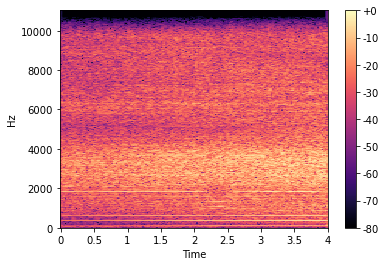

In [ ]:
# The original(linear) spectrogram
# Short Time Fourier Transform Log Spectrogram
fig, ax = plt.subplots()
D = librosa.stft(audio1_y) # STFT of y1
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db,
                        x_axis="time",
                        y_axis="linear",
                        sr=audio1_sr,
                        ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f")
plt.show()
plt.close(fig)

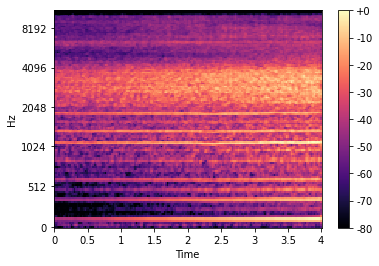

In [ ]:
# The Melspectrogram
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=audio1_y, sr=audio1_sr)
M_db = librosa.amplitude_to_db(M,ref=np.max)
img = librosa.display.specshow(M_db,
                        x_axis="time",
                        y_axis="mel",
                        ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f")
plt.show()
plt.close(fig)

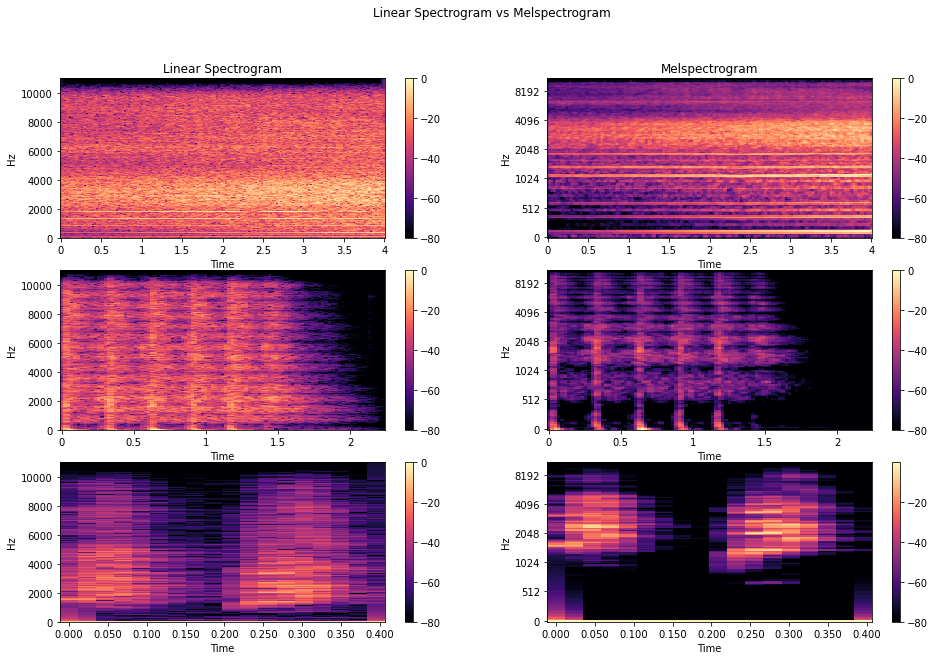

In [ ]:
# Sample Spectrograms
# Construct a subplot grid with 3 rows and 2 column
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,10))

# On the first column shows the original spectrogram

# Audio1
D1 = librosa.stft(audio1_y) # STFT of y1
S_db1 = librosa.amplitude_to_db(np.abs(D1), ref=np.max)
img1 = librosa.display.specshow(S_db1, sr=audio1_sr, x_axis='time', y_axis='linear', ax=ax[0,0])

# Audio 2
D2 = librosa.stft(audio2_y) # STFT of y1
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)
img2 = librosa.display.specshow(S_db2, sr=audio2_sr, x_axis='time', y_axis='linear', ax=ax[1,0])

# Audio 3
D3 = librosa.stft(audio3_y) # STFT of y1
S_db3 = librosa.amplitude_to_db(np.abs(D3), ref=np.max)
img3 = librosa.display.specshow(S_db3, sr=audio3_sr, x_axis='time', y_axis='linear', ax=ax[2,0])

# On the second column shows the melspectrogram

# Audio1
M1 = librosa.feature.melspectrogram(y=audio1_y, sr=audio1_sr)
M_db1 = librosa.amplitude_to_db(M1,ref=np.max)
img4 = librosa.display.specshow(M_db1, x_axis='time', y_axis='mel', ax=ax[0,1])

# Audio 2
M2 = librosa.feature.melspectrogram(y=audio2_y, sr=audio2_sr)
M_db2 = librosa.amplitude_to_db(M2,ref=np.max)
img5 = librosa.display.specshow(M_db2, x_axis='time', y_axis='mel', ax=ax[1,1])

# Audio 3
M3 = librosa.feature.melspectrogram(y=audio3_y, sr=audio3_sr)
M_db3 = librosa.amplitude_to_db(M3,ref=np.max)
img6 = librosa.display.specshow(M_db3, x_axis='time', y_axis='mel', ax=ax[2,1])

fig.suptitle("Linear Spectrogram vs Melspectrogram")
ax[0,0].set(title='Linear Spectrogram')
ax[0,1].set(title='Melspectrogram')
# And we can share colorbars:
fig.colorbar(img1, ax=[ax[0,0]])
fig.colorbar(img2, ax=[ax[1,0]])
fig.colorbar(img3, ax=[ax[2,0]])
fig.colorbar(img4, ax=[ax[0,1]])
fig.colorbar(img5, ax=[ax[1,1]])
fig.colorbar(img6, ax=[ax[2,1]])

<a id=7></a>
## Spectrogram Creation Function

In [ ]:
def create_spectrogram(input_file_path,output_file_path):
    """
    This function create melspectrogram and save as a png file
    Parameters:
    input_file_path(.wav format): Audio file path to convert spectrogram
    output_file_path: png file path where to save the picture
    """
    # Creat Spectrogram
    y, sr = librosa.load(input_file_path)
    Mel = librosa.feature.melspectrogram(y=y, sr=sr)
    Mel_db = librosa.amplitude_to_db(Mel,ref=np.max)
    
    # Visualization with matplotlib
    fig, ax = plt.subplots(nrows=1, ncols=1)
    img = librosa.display.specshow(Mel_db,
                                   x_axis="time",
                                   y_axis="mel",
                                   ax=ax)
    # Save and close figure
    plt.axis("off")
    fig.savefig(output_file_path, bbox_inches='tight', pad_inches=0)   # save the figure to png file
    #plt.show()
    plt.close(fig)

<a id=8></a>
# Preprocessing Steps
* In this section, preprocessing operations were applied to the data set
* Data converted to matrix with for loop is stored in dataframe
* Dataframe saved as csv file

<a id=9></a>
## İmage resize and gray scale

In [ ]:
def convert_grayscale_and_resize_image(filename,output_file_extension):
    """
    This function takes images and resizes them. After resize convert to graysacle.
    """
    img_r = cv.imread(filename + output_file_extension)
    input_image_size = 128
    resized_img = cv.resize(img_r, (input_image_size, input_image_size))
    gray = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
    #print("Shape: " , gray.shape)
    #cv.imshow("window", gray)
    #cv.waitKey(0) 
    #cv.destroyAllWindows()
    cv.imwrite(filename + output_file_extension,gray)

<a id=10></a>
## Data convert to matrix and save into dataframe

In [ ]:
def transfer_to_df_as_numpy_array(dataframe,classID,output_file_path):
    """
    This function takes images and their classID and add a dataframe as a matrix.
    Each row equals one image and each column equal pixel of image.
    """
    classID = np.array([int(classID)])
    img_r = cv.imread(output_file_path + output_file_extension,cv.IMREAD_GRAYSCALE)
    img_r = img_r.flatten()
    new_df_row = np.concatenate((classID,img_r),axis=0)
    images_dframe.loc[i] = new_df_row

In [ ]:
input_image_size_h = 128
input_image_size_w = 128
images_dframe = pd.DataFrame(columns=["classID" if x == 0 else "pixel" + str(x) for x in range(input_image_size_h*input_image_size_w+1)])

for i in tqdm(range(len(df["slice_file_name"]))):
    # File stats
    input_file_path = "audio/" + df["slice_file_name"].iloc[i]  # .wav format
    fsID = str(df["fsID"].iloc[i])
    classID = str(df["classID"].iloc[i])
    if not os.path.exists("spectrogram/fold_" + classID):
        os.mkdir("spectrogram/fold_" + classID)
    output_file_path = "spectrogram/" + "fold_" + str(classID)+ "/" + df["slice_file_name"].iloc[i][0:-4]
    output_file_extension = ".png"
    
    # This lines created to test code
    #print("Input file path: " , input_file_path)
    #print("fsID: " , fsID)
    #print("Class: " , classID)
    #print("Output file path: " , output_file_path)
    
    # Create spectrogram and save as png
    create_spectrogram(input_file_path,output_file_path)
    convert_grayscale_and_resize_image(output_file_path,output_file_extension)
    
    # Exporting all images to dataframe to save as csv
    transfer_to_df_as_numpy_array(images_dframe,classID,output_file_path)

100%|██████████| 8732/8732 [47:40<00:00,  3.05it/s]  


In [ ]:
images_dframe.head()

classID  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        3       0       0       0       0       0       0       0       0   
1        2       0       0       0       0       0       0       0       0   
2        2       0       0       0       0       0       0       0       0   
3        2       0       0       0       0       0       0       0       0   
4        2       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel16375  pixel16376  pixel16377  pixel16378  pixel16379  \
0       0  ...           0           0           0           0           0   
1       0  ...         164         156         173         190         170   
2       0  ...         104          98         133         115         122   
3       0  ...         147         135          99         110          95   
4       0  ...         225         207         197         211         225   

   pixel16380  pixel16381  pixel16382  pixel16383  pixel16384  
0           0           0           0           0           0  
1         174         191         192         192         152  
2         150         172         132         149         160  
3          81         133         163         135         116  
4         216         212         225         213         177  

[5 rows x 16385 columns]

In [ ]:
images_dframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8732 entries, 0 to 8731
Columns: 16385 entries, classID to pixel16384
dtypes: int32(16385)
memory usage: 545.8 MB


<a id=11></a>
## Saving data as test and train

In [ ]:
y = images_dframe.loc[:,["classID"]]
x = images_dframe.drop(columns="classID",axis=1)

In [ ]:
print("x shape: ", x.shape)
x.head()

x shape:  (8732, 16384)


pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel16375  pixel16376  pixel16377  pixel16378  pixel16379  \
0        0  ...           0           0           0           0           0   
1        0  ...         164         156         173         190         170   
2        0  ...         104          98         133         115         122   
3        0  ...         147         135          99         110          95   
4        0  ...         225         207         197         211         225   

   pixel16380  pixel16381  pixel16382  pixel16383  pixel16384  
0           0           0           0           0           0  
1         174         191         192         192         152  
2         150         172         132         149         160  
3          81         133         163         135         116  
4         216         212         225         213         177  

[5 rows x 16384 columns]

In [ ]:
print("y shape: ", y.shape)
y.head()

y shape:  (8732, 1)


classID
0        3
1        2
2        2
3        2
4        2

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2,random_state=20)
print("x_train shape: " , X_train.shape)
print("x_test shape: " , X_test.shape)
print("y_train shape: " , Y_train.shape)
print("y_test shape: " , Y_test.shape)

x_train shape:  (6985, 16384)
x_test shape:  (1747, 16384)
y_train shape:  (6985, 1)
y_test shape:  (1747, 1)


In [ ]:
train = pd.concat([Y_train,X_train],axis=1).reset_index(drop=True)
test = pd.concat([Y_test,X_test],axis=1).reset_index(drop=True)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (6985, 16385)
Test shape:  (1747, 16385)


In [ ]:
test.head()

classID  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        5       0       0       0       0       0       0       0       0   
1        7       0       0       0       0       0       0       0       0   
2        5       0       0       0       0       0       0       0       0   
3        4       0       0       0       0       0       0       0       0   
4        3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel16375  pixel16376  pixel16377  pixel16378  pixel16379  \
0       0  ...         132         131         128         173         123   
1       0  ...          49          61          55          93          64   
2       0  ...         188         200         185         198         208   
3       0  ...           0           0          10           6           0   
4       0  ...          38          35          35           0           0   

   pixel16380  pixel16381  pixel16382  pixel16383  pixel16384  
0         124         125         102         115         122  
1          71          92         107          85          98  
2         190         194         209         192         168  
3           0           0           0           0           5  
4           0          12          33          39          44  

[5 rows x 16385 columns]

In [ ]:
train.head()

classID  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        0       0       0       0       0       0       0       0       0   
1        7       0       0       0       0       0       0       0       0   
2        1       0       0       0       0       0       0       0       0   
3        1       0       0       0       0       0       0       0       0   
4        5       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel16375  pixel16376  pixel16377  pixel16378  pixel16379  \
0       0  ...         189         152         176         154         135   
1       0  ...          57          59          68          79          56   
2       0  ...         132         132         132         132         133   
3       0  ...           0           0           0           0           0   
4       0  ...         163         143         181         173         176   

   pixel16380  pixel16381  pixel16382  pixel16383  pixel16384  
0         117         128         165         169         178  
1          38          90          95          38          37  
2         145         145         145         145         145  
3           0           0           0           0           0  
4         190         174         168         178         146  

[5 rows x 16385 columns]

In [ ]:
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)

In [ ]:
# Test code
df_train = pd.read_csv("train.csv")
print(df_train.shape)

(6985, 16385)


In [ ]:
df_train.head()

classID  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        0       0       0       0       0       0       0       0       0   
1        7       0       0       0       0       0       0       0       0   
2        1       0       0       0       0       0       0       0       0   
3        1       0       0       0       0       0       0       0       0   
4        5       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel16375  pixel16376  pixel16377  pixel16378  pixel16379  \
0       0  ...         189         152         176         154         135   
1       0  ...          57          59          68          79          56   
2       0  ...         132         132         132         132         133   
3       0  ...           0           0           0           0           0   
4       0  ...         163         143         181         173         176   

   pixel16380  pixel16381  pixel16382  pixel16383  pixel16384  
0         117         128         165         169         178  
1          38          90          95          38          37  
2         145         145         145         145         145  
3           0           0           0           0           0  
4         190         174         168         178         146  

[5 rows x 16385 columns]